# Quantile-quantile (QQ) scaled climate projections

In [1]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask
import cmocean

from calc_adjustment import read_data

Matplotlib is building the font cache; this may take a moment.


In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
# Parameters
example_lat = -42.9
example_lon = 147.3
example_month = 6

In [4]:
adjustment_file = "/g/data/wp00/users/dbi599/test_space/pr-qqscale-factors-multiplicative_day_ACCESS-ESM1-5_historical-ssp370_r1i1p1f1_19950101-20141231_20350101-20641231_freq-adapt-0.5mm.nc"
qq_file = "/g/data/wp00/users/dbi599/test_space/pr-qqscaled-multiplicative_day_AGCD-ACCESS-ESM1-5_ssp370_r1i1p1f1_20350101-20641231_freq-adapt-0.5mm.nc"
qq_no_adapt_file = "/g/data/wp00/users/dbi599/test_space/pr-qqscaled-multiplicative_day_AGCD-ACCESS-ESM1-5_ssp370_r1i1p1f1_20350101-20641231.nc"
#example_lat = -23.7
#example_lon = 133.88
example_lat = -12.46
#example_lon = 130.84
example_lon = 129
example_month = 6
hist_units = "kg m-2 s-1"
ref_units = "kg m-2 s-1"
target_units = "mm d-1"
output_units = "mm d-1"
hist_var = "pr"
ref_var = "pr"
target_var = "precip"
hist_files = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc"
ref_files = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc"
target_files = "/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19000101-20220405_daily_space-chunked.zarr"
hist_time_bounds = "1995-01-01 2014-12-31"
ref_time_bounds = "2035-01-01 2064-12-31"
target_time_bounds = "1990-01-01 2019-12-31"

In [5]:
# Required parameters
assert 'hist_var' in locals(), "Must provide an historical variable name (option -p hist_var {name})"
assert 'ref_var' in locals(), "Must provide a reference variable name (option -p ref_var {name})"
assert 'target_var' in locals(), "Must provide a target variable name (option -p target_var {name})"
assert 'hist_units' in locals(), "Must provide historical units (option -p hist_units {units})"
assert 'ref_units' in locals(), "Must provide reference units (option -p ref_units {units})"
assert 'target_units' in locals(), "Must provide target units (option -p target_units {units})"
assert 'output_units' in locals(), "Must provide output units (option -p output_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'ref_files' in locals(), """Must provide reference data files (option -p ref_files {"file paths"})"""
assert 'target_files' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'ref_time_bounds' in locals(), """Must provide time bounds for reference data (option -p ref_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'target_time_bounds' in locals(), """Must provide time bounds for target data (option -p target_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [6]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

if hist_var in ['tasmax']:
    regular_cmap = 'hot_r'
    diverging_cmap = 'RdBu_r'
elif hist_var in ['tasmin']:
    regular_cmap = cmocean.cm.ice
    diverging_cmap = 'RdBu_r'
elif hist_var in ['pr']:
    regular_cmap = cmocean.cm.rain
    diverging_cmap = 'BrBG'
else:
    raise ValueError(f'No cmap defined for {hist_var}')

## Read data

In [7]:
ds_target = read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [8]:
ds_target[target_var]

<xarray.DataArray 'precip' (time: 10957, lat: 691, lon: 886)>
dask.array<xarray-precip, shape=(10957, 691, 886), dtype=float32, chunksize=(10957, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * time     (time) datetime64[ns] 1990-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    analysis_time:                 2010-10-23 14:49:46 UTC
    analysis_version_number:       3.01
    cell_methods:                  time: sum
    frequency:                     daily
    length_scale_for_analysis:     80.0
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    standard_name:                 lwe_thickness_of_precipitation_amount
    units:                         mm d-1

In [9]:
ds_hist = read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units)
ds_hist[hist_var]

<xarray.DataArray 'pr' (time: 7305, lat: 145, lon: 192)>
dask.array<mul, shape=(7305, 145, 192), dtype=float32, chunksize=(7305, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T17:41:46Z altered by CMOR: replaced missing va...

[########################################] | 100% Completed |  4.7s


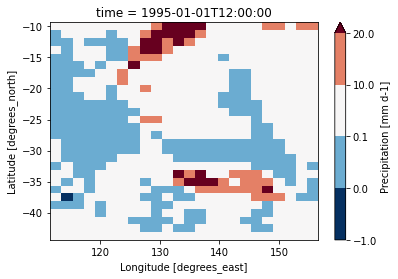

In [59]:
ds_hist['pr'].isel({'time': 0}).sel({'lat': slice(lat_min_qq, lat_max_qq), 'lon': slice(lon_min_qq, lon_max_qq)}).plot(
    levels=[-1, 0, 0.1, 10, 20]    
)

In [61]:
ds_hist['pr'].isel({'time': 0}).sel({'lat': slice(lat_min_qq, lat_max_qq), 'lon': slice(lon_min_qq, lon_max_qq)}).values

[########################################] | 100% Completed |  4.7s


array([[ 2.00631022e-01,  4.87484127e-01,  3.47709656e+00,
         5.47095394e+00,  3.55669975e+00,  2.03578138e+00,
         2.44538665e+00,  1.48094964e+00,  9.35534060e-01,
         1.05253923e+00,  1.05747521e+00,  1.86315045e-01,
         2.92981774e-01,  3.52376312e-01,  2.85861850e-01,
         5.06897151e-01,  4.49096054e-01,  4.96182710e-01,
         5.67492664e-01,  5.26175618e-01,  7.20047176e-01,
         6.17574871e-01,  4.69671994e-01,  9.91582572e-01],
       [ 7.40747809e-01,  6.08485758e-01,  4.87197250e-01,
         5.01012623e-01,  3.04231942e-01,  4.13934141e-01,
         2.49661312e-01,  1.53193980e-01,  9.89777744e-02,
         7.86937699e-02,  1.91675276e-01,  8.87331665e-02,
         6.33705929e-02,  1.25419855e-01,  6.60537601e-01,
         4.17756110e-01,  6.21704400e-01,  1.06040013e+00,
         3.05550117e-02,  1.31544871e-02,  5.02961099e-01,
         4.34920222e-01,  9.64092255e-01,  1.61962008e+00],
       [ 4.80813891e-01,  2.45961845e-01,  4.54481870e

In [10]:
ds_ref = read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units)
ds_ref[ref_var]

<xarray.DataArray 'pr' (time: 10958, lat: 145, lon: 192)>
dask.array<mul, shape=(10958, 145, 192), dtype=float32, chunksize=(10958, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2035-01-01T12:00:00 ... 2064-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T10:39:53Z altered by CMOR: replaced missing va...

In [11]:
ds_adjust = xr.open_dataset(adjustment_file)
ds_adjust

<xarray.Dataset>
Dimensions:          (lon: 192, lat: 145, month: 12, quantiles: 100)
Coordinates:
  * lon              (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * lat              (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles        (quantiles) float64 0.005 0.015 0.025 ... 0.975 0.985 0.995
Data variables:
    af               (quantiles, month, lat, lon) float32 ...
    hist_q           (quantiles, month, lat, lon) float32 ...
    hist_q_no_adapt  (quantiles, month, lat, lon) float32 ...
    af_no_adapt      (quantiles, month, lat, lon) float32 ...
    ref_q            (quantiles, month, lat, lon) float32 ...
Attributes:
    _xclim_adjustment:        {"py/object": "xclim.sdba.adjustment.EmpiricalQ...
    adj_params:               EmpiricalQuantileMapping(group=Grouper(add_dims...
    history:                  Mon Nov 21 09:50:02 2022: /g/data/xv83/dbi599/m...
    historical_period_start:  1995-01-01
    historical_period_end:    2014-12-31
    reference_period_start:   2035-01-01
    reference_period_end:     2064-12-31

In [12]:
#qm = sdba.QuantileDeltaMapping.from_dataset(ds_adjust)

In [13]:
ds_qq = xr.open_dataset(qq_file)

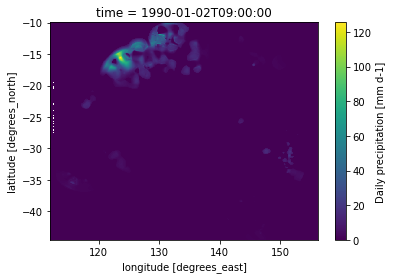

In [14]:
ds_qq['precip'].isel(time=1).plot()

In [15]:
ds_no_adapt_qq = xr.open_dataset(qq_no_adapt_file)

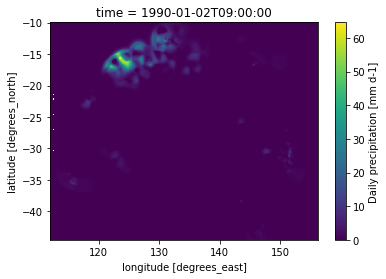

In [16]:
ds_no_adapt_qq['precip'].isel(time=1).plot()

In [17]:
lat_min_qq = ds_qq['lat'].values.min()
lat_max_qq = ds_qq['lat'].values.max()
lon_min_qq = ds_qq['lon'].values.min()
lon_max_qq = ds_qq['lon'].values.max()

In [18]:
print(lat_min_qq, lat_max_qq, lon_min_qq, lon_max_qq)

-44.5 -10.0 112.0 156.25


## Quantile mapping

In [19]:
def quantile_month_plot(da, ax, cmap=None, diverging=False, point=None, levels=None, title=None):
    """Create two dimensional month/quantile plot"""
    
    if 'lat' in da.dims:
        point_selection = {'lat': example_lat, 'lon': example_lon}
    else:
        point_selection = {}
    quantiles = da.sel(point_selection, method='nearest')

    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif diverging:
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
    
    quantiles.transpose('month', 'quantiles').plot(ax=ax, cmap=cmap, **kwargs)
    
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    ax.set_yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    if title:
        ax.set_title(title)


In [20]:
def quantile_spatial_plot(
    da, month, lat_bounds=None, lon_bounds=None, cmap=None, diverging=False,
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [.1, .5, .9], 'month': month}, method='nearest')
    if lat_bounds:
        lat_min, lat_max = lat_bounds
        da_selection = da_selection.sel(lat=slice(lat_min, lat_max))
    if lon_bounds:
        lon_min, lon_max = lon_bounds
        da_selection = da_selection.sel(lon=slice(lon_min, lon_max))
    if diverging:
        abs_max = np.max(np.abs(da_selection.values))
        vmax = abs_max
        vmin = -1 * abs_max
    else:
        vmin = vmax = None
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree(),},
        levels=[0.125, 0.25, 0.5, 1, 2, 4, 8]
    )
    for ax in p.axes.flat:
        ax.coastlines()
        ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

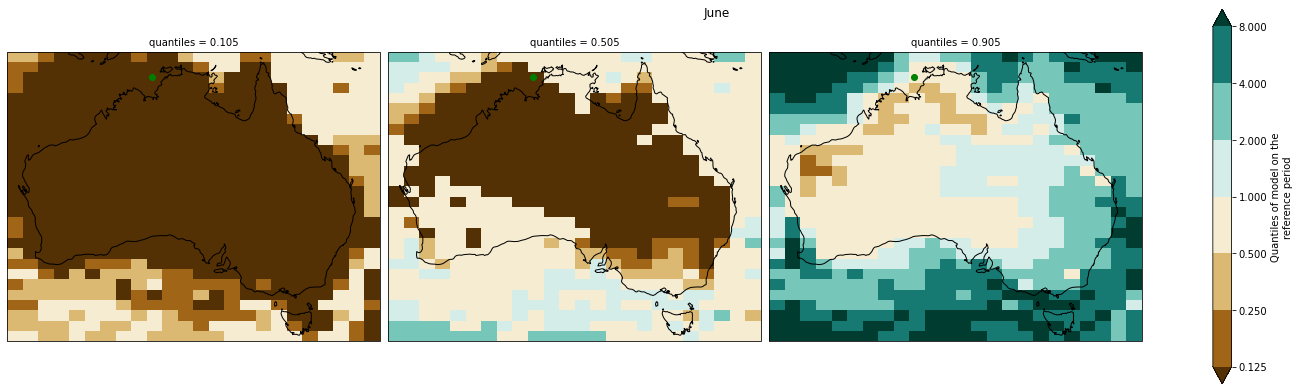

In [22]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['hist_q'],
        example_month,
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
        cmap=diverging_cmap,
    )

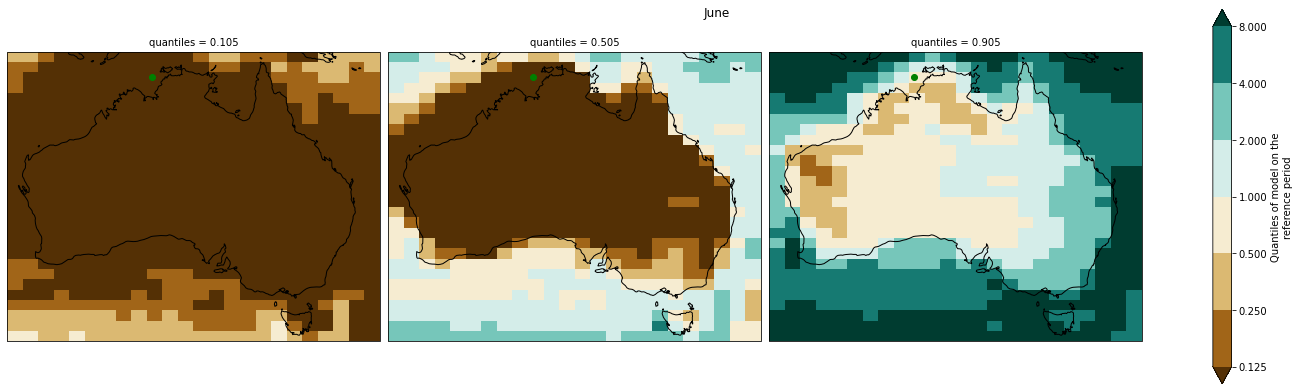

In [23]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['hist_q_no_adapt'],
        example_month,
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
        cmap=diverging_cmap,
    )

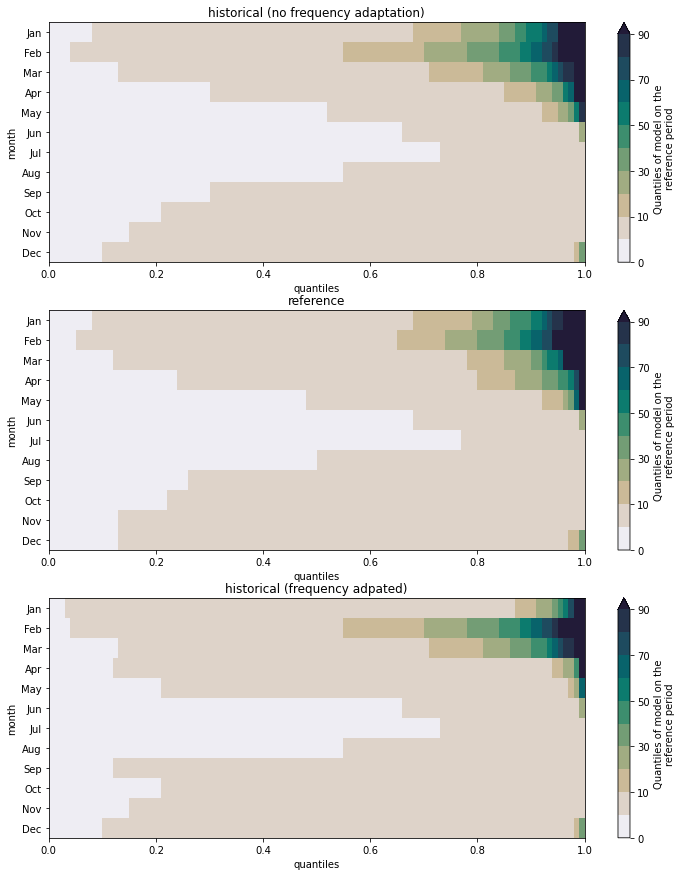

In [24]:
fig = plt.figure(figsize=[12, 15])
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

quantile_month_plot(
    ds_adjust['hist_q_no_adapt'],
    ax1,
    cmap=regular_cmap,
    levels=[0, 0.01, 10, 20, 30, 40, 50, 60, 70, 80, 90],
    title='historical (no frequency adaptation)'
)

quantile_month_plot(
    ds_adjust['ref_q'],
    ax2,
    cmap=regular_cmap,
    levels=[0, 0.01, 10, 20, 30, 40, 50, 60, 70, 80, 90],
    title='reference',
)

quantile_month_plot(
    ds_adjust['hist_q'],
    ax3,
    cmap=regular_cmap,
    levels=[0, 0.01, 10, 20, 30, 40, 50, 60, 70, 80, 90],
    title='historical (frequency adpated)'
)

plt.show()

In [67]:
ds_adjust['hist_q'].sel({'lat': example_lat, 'lon': example_lon, 'month': 6}, method='nearest')

<xarray.DataArray 'hist_q' (quantiles: 100)>
array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 5.060425e-06, 1.511601e-05,
       8.270779e-05, 1.399479e-04, 2.322192e-04, 3.568238e-04, 5.404805e-04,
       1.214306e-03, 1.743832e-03, 2.219083e-03, 4.278220e-03, 4.708456e-03,
       6.987512e-03, 1.101330e-02, 1.307951e-02, 1.554987e-02, 1.960289e-02,
       2.336275e-02, 2.593421e-02, 3.072654e-02, 3.742906e-02, 4.544979e-02,
       5.155536e-02, 5.530106e-02, 8.868276e-02, 9.650081e-02, 1.117542e-01,
       1.271333e-01, 1.449281e-01, 1.648752e-01, 1.857806e-01, 2.063607e-01,
       2.685828e-01, 3.070377e-01, 3.798884e-01, 4.748919e-01, 6.165540e-01,
       7.366883e-01, 9.184644e-01, 1.304895e+00, 1.504006e+00, 2.164850e+00,
       3.050711e+00, 3.799352e+00, 6.141405e+00, 9.448883e+00, 2.063088e+01],
      dtype=float32)
Coordinates:
    lon        float64 129.4
    lat        float64 -12.5
    month      int64 6
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Attributes:
    standard_name:  Model quantiles
    long_name:      Quantiles of model on the reference period

The adjustment factor is ref / hist, so when hist has more dry days it's a problem.

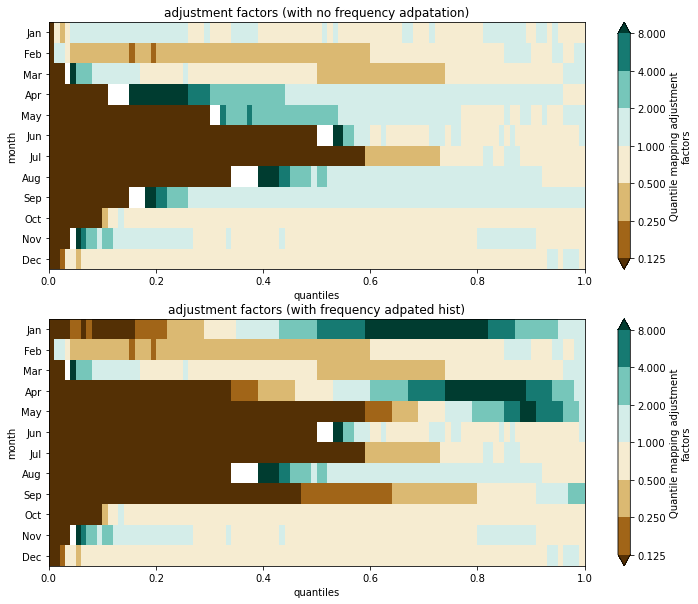

In [25]:
fig = plt.figure(figsize=[12, 10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

quantile_month_plot(
    ds_adjust['af_no_adapt'].fillna(0),
    ax1,
    cmap=diverging_cmap,
    levels=[0.125, 0.25, 0.5, 1, 2, 4, 8],
    title='adjustment factors (with no frequency adpatation)'
)

quantile_month_plot(
    ds_adjust['af'].fillna(0),
    ax2,
    cmap=diverging_cmap,
    levels=[0.125, 0.25, 0.5, 1, 2, 4, 8],
    title='adjustment factors (with frequency adpated hist)'
)

plt.show()

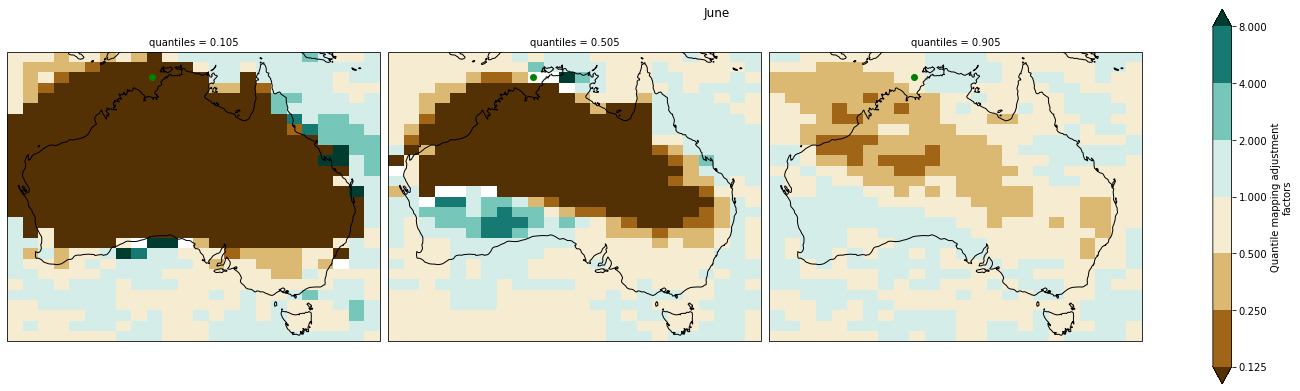

In [26]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['af_no_adapt'].fillna(0),
        example_month,
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
        cmap=diverging_cmap,
        diverging=True,
    )

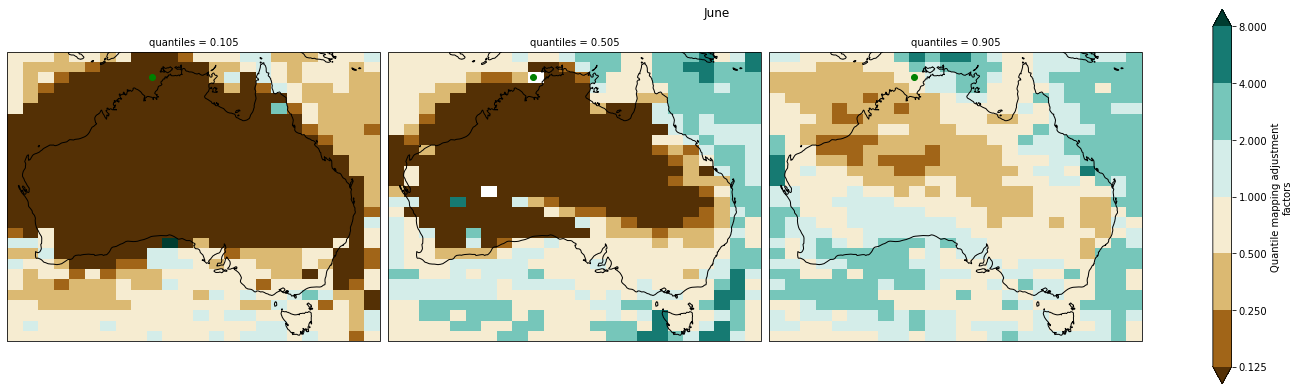

In [27]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['af'].fillna(0),
        example_month,
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
        cmap=diverging_cmap,
        diverging=True,
    )

## QQ-scaled data

In [28]:
model_sel = {'lat': slice(lat_min_qq, lat_max_qq), 'lon': slice(lon_min_qq, lon_max_qq)}

In [29]:
hist_clim = ds_hist[hist_var].mean('time', keep_attrs=True)
ref_clim = ds_ref[ref_var].mean('time', keep_attrs=True)
target_clim = ds_target[target_var].mean('time', keep_attrs=True)
qq_clim = ds_qq[target_var].mean('time', keep_attrs=True)

In [36]:
qq_no_adapt_clim = ds_no_adapt_qq[target_var].mean('time', keep_attrs=True)

[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.8s


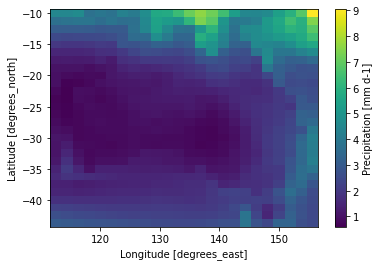

In [61]:
hist_clim.sel(model_sel).plot()

[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  8.9s


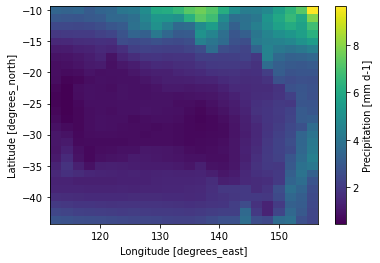

In [62]:
ref_clim.sel(model_sel).plot()

[########################################] | 100% Completed |  3min 16.7s
[########################################] | 100% Completed |  3min 16.8s


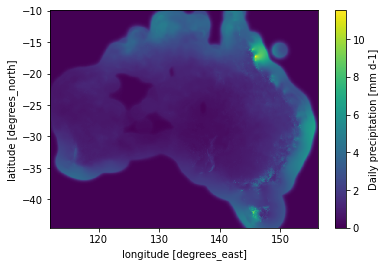

In [63]:
target_clim.plot()

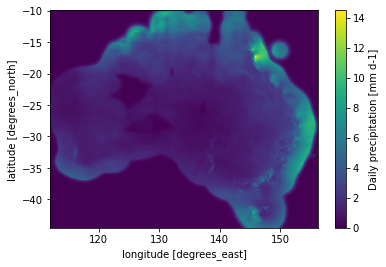

In [64]:
qq_clim.plot()

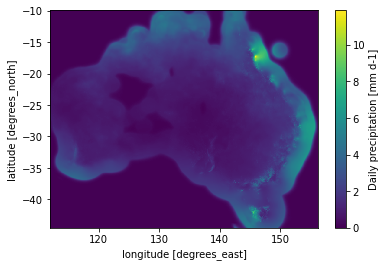

In [37]:
qq_no_adapt_clim.plot()

In [30]:
if len(hist_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(hist_clim, qq_clim, "bilinear")
    hist_clim = regridder(hist_clim)

if len(ref_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(ref_clim, qq_clim, "bilinear")
    ref_clim = regridder(ref_clim)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key i

[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.9s


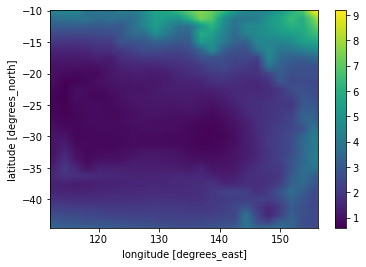

In [66]:
hist_clim.sel(model_sel).plot()

In [31]:
hist_ref_mean_diff = ref_clim - hist_clim
hist_ref_mean_diff = hist_ref_mean_diff.compute()

[########################################] | 100% Completed | 36.3s


In [32]:
qq_mean_change = qq_clim - target_clim
qq_mean_change = qq_mean_change.compute()

[########################################] | 100% Completed |  6min 16.8s


In [38]:
qq_no_adapt_mean_change = qq_no_adapt_clim - target_clim
qq_no_adapt_mean_change = qq_no_adapt_mean_change.compute()

[########################################] | 100% Completed |  1min 44.1s


In [33]:
difference = qq_mean_change - hist_ref_mean_diff

In [39]:
difference_no_adapt = qq_no_adapt_mean_change - hist_ref_mean_diff

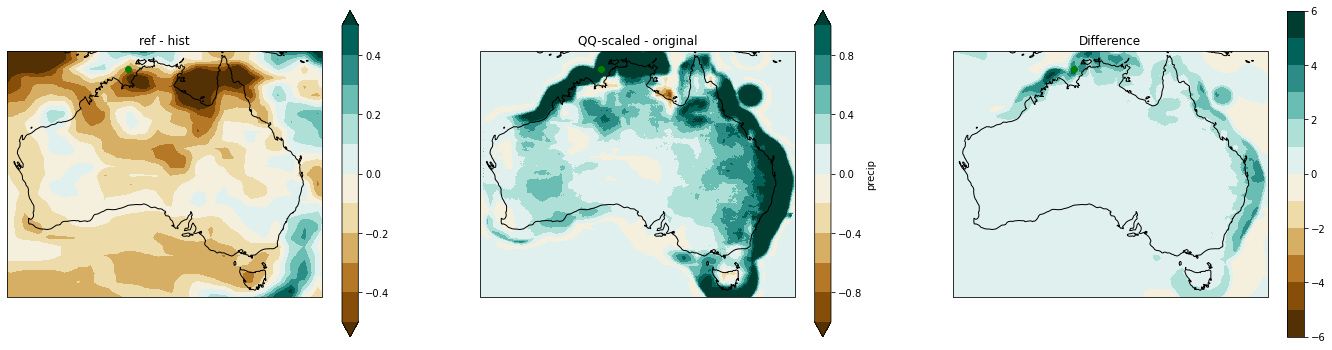

In [40]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
hist_ref_mean_diff.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=diverging_cmap,
    levels=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
)
ax1.set_title('ref - hist')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
qq_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=diverging_cmap,
    levels=[-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
    extend='both'
)
ax2.set_title('QQ-scaled - original')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
difference.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=diverging_cmap,
    levels=13,
)
ax3.set_title('Difference')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.show()

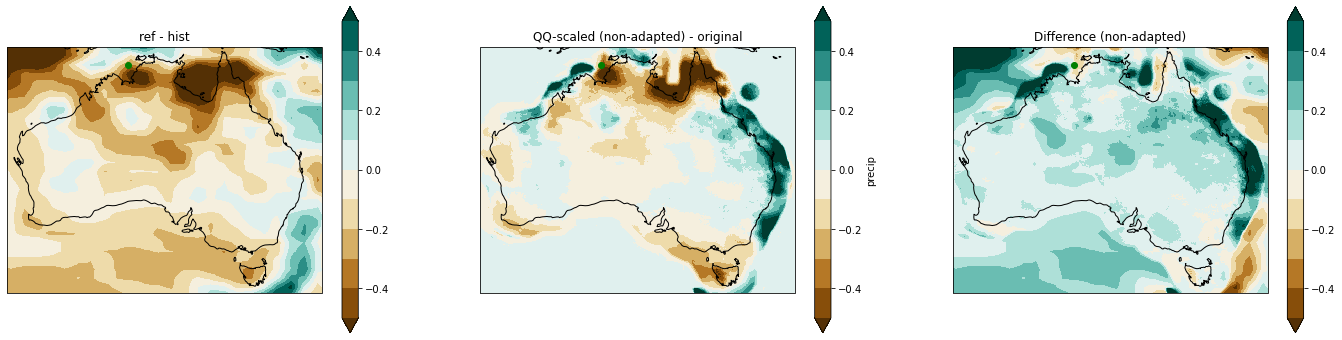

In [43]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
hist_ref_mean_diff.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=diverging_cmap,
    levels=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
)
ax1.set_title('ref - hist')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
qq_no_adapt_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=diverging_cmap,
    levels=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
    extend='both'
)
ax2.set_title('QQ-scaled (non-adapted) - original')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
difference_no_adapt.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=diverging_cmap,
    levels=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
)
ax3.set_title('Difference (non-adapted)')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.show()

[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.9s


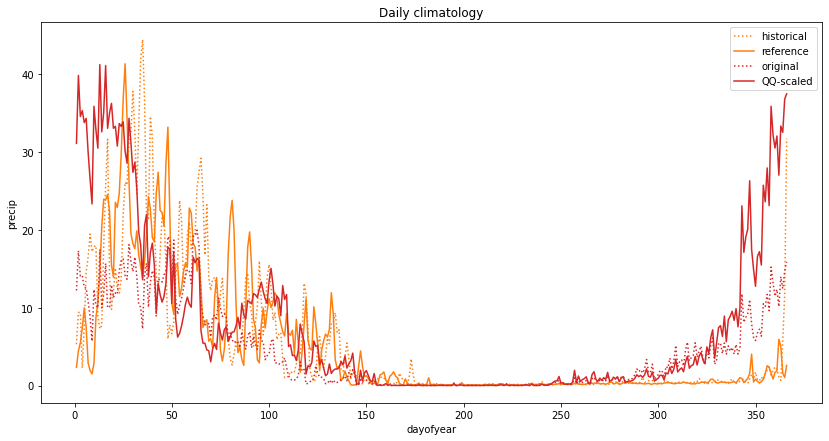

In [74]:
fig, ax = plt.subplots(figsize=[14, 7])
if 'lat' in ds_qq.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_hist[hist_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="historical", color='tab:orange', linestyle=':')
ds_ref[ref_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="reference", color='tab:orange')
ds_target[target_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="original", color='tab:red', linestyle=':')
ds_qq[target_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="QQ-scaled", color='tab:red')
plt.legend()
plt.title('Daily climatology')
plt.show()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s


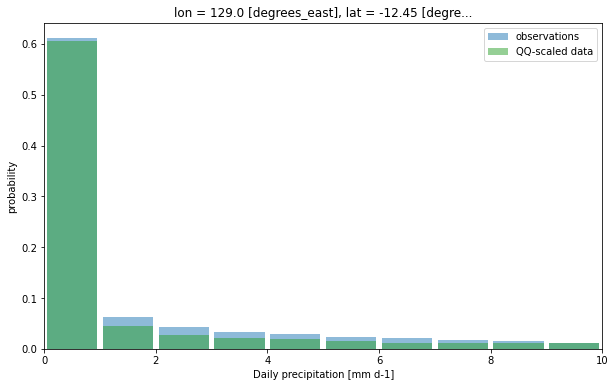

In [95]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)

if 'lat' in ds_qq.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
    
ds_target[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='observations',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
ds_qq[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='QQ-scaled data',
    facecolor='tab:green',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.xlim(0, 10)
plt.legend()
plt.show()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s


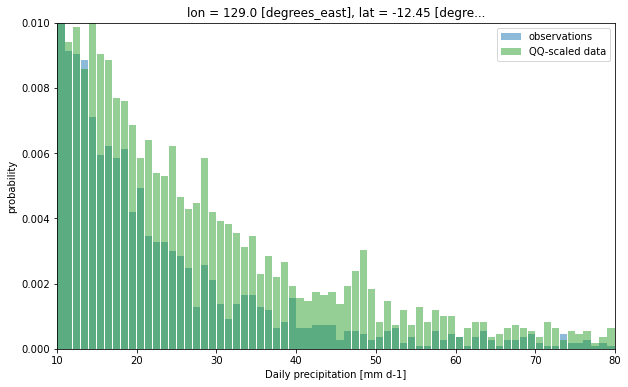

In [93]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)

if 'lat' in ds_qq.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
    
ds_target[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='observations',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
ds_qq[target_var].sel(point_selection, method='nearest').plot.hist(
    bins=bins,
    density=True,
    label='QQ-scaled data',
    facecolor='tab:green',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.ylim(0, 0.01)
plt.xlim(10, 80)
plt.legend()
plt.show()

In [80]:
ds_hist

<xarray.Dataset>
Dimensions:    (time: 7305, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(7305, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(7305, 145, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(7305, 192, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(7305, 145, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    creation_date:          2019-11-15T17:41:46Z
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/585d8ccf-c461-43d5-83e1-4843ec6ba2a7
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [85]:
(1 - np.random.rand(2,3)) * (8.64e-4)

array([[0.00025526, 0.00038319, 0.00044596],
       [0.00019671, 0.00072049, 0.00023347]])

In [93]:
test = ds_hist['pr'].isel(time=0).sel(model_sel)

In [95]:
test.values

[########################################] | 100% Completed |  4.7s


array([[ 2.00631022e-01,  4.87484127e-01,  3.47709656e+00,
         5.47095394e+00,  3.55669975e+00,  2.03578138e+00,
         2.44538665e+00,  1.48094964e+00,  9.35534060e-01,
         1.05253923e+00,  1.05747521e+00,  1.86315045e-01,
         2.92981774e-01,  3.52376312e-01,  2.85861850e-01,
         5.06897151e-01,  4.49096054e-01,  4.96182710e-01,
         5.67492664e-01,  5.26175618e-01,  7.20047176e-01,
         6.17574871e-01,  4.69671994e-01,  9.91582572e-01],
       [ 7.40747809e-01,  6.08485758e-01,  4.87197250e-01,
         5.01012623e-01,  3.04231942e-01,  4.13934141e-01,
         2.49661312e-01,  1.53193980e-01,  9.89777744e-02,
         7.86937699e-02,  1.91675276e-01,  8.87331665e-02,
         6.33705929e-02,  1.25419855e-01,  6.60537601e-01,
         4.17756110e-01,  6.21704400e-01,  1.06040013e+00,
         3.05550117e-02,  1.31544871e-02,  5.02961099e-01,
         4.34920222e-01,  9.64092255e-01,  1.61962008e+00],
       [ 4.80813891e-01,  2.45961845e-01,  4.54481870e

In [98]:
test.shape

(28, 24)

In [102]:
random_numbers = (1.0 - np.random.random_sample(test.shape)) * (8.64e-4)

In [104]:
random_numbers.shape

(28, 24)

In [106]:
test

<xarray.DataArray 'pr' (lat: 28, lon: 24)>
dask.array<getitem, shape=(28, 24), dtype=float32, chunksize=(28, 24), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1995-01-01T12:00:00
  * lat      (lat) float64 -43.75 -42.5 -41.25 -40.0 ... -12.5 -11.25 -10.0
  * lon      (lon) float64 112.5 114.4 116.2 118.1 ... 150.0 151.9 153.8 155.6
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T17:41:46Z altered by CMOR: replaced missing va...

[########################################] | 100% Completed |  4.7s


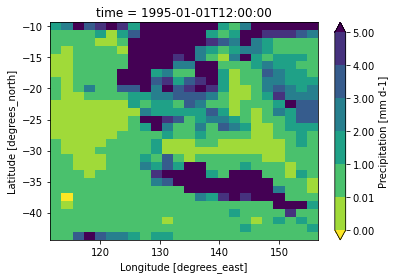

In [92]:
ds_hist['pr'].isel(time=0).sel(model_sel).plot(levels=[0, 0.01, 1, 2, 3, 4, 5], cmap='viridis_r')

[########################################] | 100% Completed |  4.7s


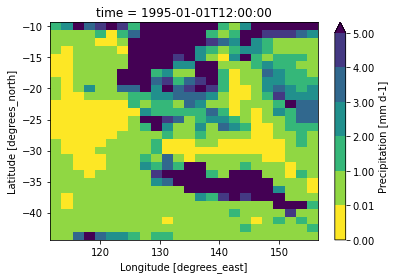

In [114]:
test.where(test >= 8.64e-4, random_numbers).plot(levels=[0, 0.01, 1, 2, 3, 4, 5], cmap='viridis_r')

In [108]:
test < 8.64e-4

<xarray.DataArray 'pr' (lat: 28, lon: 24)>
dask.array<lt, shape=(28, 24), dtype=bool, chunksize=(28, 24), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1995-01-01T12:00:00
  * lat      (lat) float64 -43.75 -42.5 -41.25 -40.0 ... -12.5 -11.25 -10.0
  * lon      (lon) float64 112.5 114.4 116.2 118.1 ... 150.0 151.9 153.8 155.6

In [116]:
ds_hist['pr'].shape

(7305, 145, 192)

In [118]:
random_numbers = (1.0 - np.random.random_sample(ds_hist['pr'].shape)) * (8.64e-4)

In [119]:
hello = ds_hist['pr'].where(ds_hist['pr'] >= 8.64e-4, random_numbers)